In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from marginal import MarginalExplainer
import plot
import matplotlib.pyplot as plt
import utils

In [4]:
n = 50000
lamb = 0.5
d = (8, 8, 3)
epochs = 50
hidden_layers = 64
batch_size = 50
learning_rate = 0.001

In [5]:
X = np.random.randn(n, *d).astype(np.float32)
y = (np.sum(X[:, 1, :, 1], axis=-1) > 0).astype(np.float32) + \
    (np.sum(X[:, 1, :, 1], axis=-1) > 1).astype(np.float32) + \
    np.sum(X[:, 0, :, 0], axis=-1) * lamb

y = y.astype(np.float32)

X_train = X[:int(n * 0.8)]
y_train = y[:int(n * 0.8)]
X_val   = X[int(n * 0.8):]
y_val   = y[int(n * 0.8):]

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=d, batch_size=batch_size))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [8]:
model.fit(X_train, y_train, epochs=epochs, verbose=2, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 - 2s - loss: 2.5415 - mean_absolute_error: 1.2839 - val_loss: 2.0170 - val_mean_absolute_error: 1.1424
Epoch 2/50
40000/40000 - 2s - loss: 1.3474 - mean_absolute_error: 0.9260 - val_loss: 0.8835 - val_mean_absolute_error: 0.7513
Epoch 3/50
40000/40000 - 2s - loss: 0.7237 - mean_absolute_error: 0.6825 - val_loss: 0.6357 - val_mean_absolute_error: 0.6395
Epoch 4/50
40000/40000 - 2s - loss: 0.5790 - mean_absolute_error: 0.6117 - val_loss: 0.5513 - val_mean_absolute_error: 0.5967
Epoch 5/50
40000/40000 - 2s - loss: 0.5146 - mean_absolute_error: 0.5774 - val_loss: 0.5050 - val_mean_absolute_error: 0.5719
Epoch 6/50
40000/40000 - 2s - loss: 0.4736 - mean_absolute_error: 0.5546 - val_loss: 0.4721 - val_mean_absolute_error: 0.5540
Epoch 7/50
40000/40000 - 2s - loss: 0.4437 - mean_absolute_error: 0.5378 - val_loss: 0.4482 - val_mean_absolute_error: 0.5401
Epoch 8/50
40000/40000 - 2s - loss: 0.4206 - mean_absolute_error: 0.

In [9]:
num_shap_samples=10

In [27]:
primal_explainer = MarginalExplainer(model, np.zeros((1, 8, 8, 3)).astype(np.float32), nsamples=200, representation='mobius')
primal_effects = primal_explainer.explain(X[:num_shap_samples], verbose=True)


100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

In [26]:
model_func = lambda x: model(x.reshape(x.shape[0], 8, 8, 3).astype(np.float32)).numpy()
kernel_explainer = shap.KernelExplainer(model_func, np.zeros((1, 192)))
shap_values = kernel_explainer.shap_values(X[:num_shap_samples].reshape(num_shap_samples, -1), num_samples=200)
shap_values = np.reshape(shap_values, (10, 8, 8, 3))


  0%|          | 0/10 [00:00<?, ?it/s]/home/psturm/.local/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \

 10%|█         | 1/10 [00:00<00:02,  3.46it/s]/home/psturm/.local/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \

 20%|██        | 2/10 [00:00<00:02,  3.46it/s]/home/psturm/.local/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditi

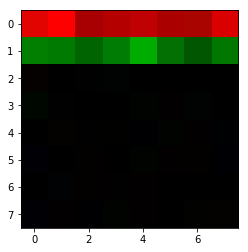

In [28]:
shap_values_mean_abs = np.mean(np.abs(shap_values), axis=0)
plt.imshow(utils.normalize(shap_values_mean_abs, _range=[0.0, 1.0], _domain=[0.0, shap_values_mean_abs.max()]))

W1101 14:52:43.805624 140375857694528 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


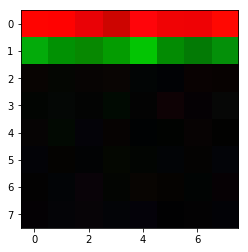

In [29]:
primal_mean_abs = np.mean(np.abs(primal_effects), axis=0)
plt.imshow(utils.normalize(primal_mean_abs, _range=[0.0, 1.0], _domain=[0.0, shap_values_mean_abs.max()]))

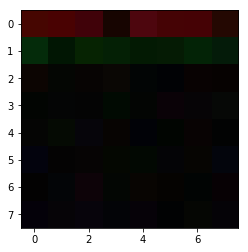

In [30]:
interactions_mean_abs = np.mean(np.abs(shap_values - primal_effects), axis=0)
plt.imshow(utils.normalize(interactions_mean_abs, _range=[0.0, 1.0], _domain=[0.0, shap_values_mean_abs.max()]))